In [1]:
from pragmaticquant import market

mkt_datas = market.MarketDatas.load_json('mkt.json')
mkt = market.Market(mkt_datas)
print('Market RefDate = %s' % mkt.refdate())

Market RefDate = 2015-04-29 00:00:00


In [2]:
from pragmaticquant import payoffs

def put_redemption(maturity, paycurrency, underlying, put_strike):
    return payoffs.DslCoupon(maturity, paycurrency,
                             id='PutRedemption',
                             script='1-Max(0.0, 1.0 - Index@FixingDate / Strike)',
                             Index=payoffs.equity_spot(underlying), 
                             FixingDate=maturity, 
                             Strike=put_strike)

def pdi_redemption(maturity, paycurrency, underlying, put_strike, ki_limit, ki_start, ki_frequency):
    return payoffs.DslCoupon(maturity, paycurrency,
                             id='PDIRedemption',
                             script ="1 - Max(0.0, 1.0 - Index@FixingDate / Strike) * (KI_Index@FixingDate < KI ? 1.0 : 0.0 )",
                             Index = payoffs.equity_spot(underlying), 
                             FixingDate = maturity, 
                             Strike = put_strike,
                             KI = ki_limit,
                             KI_Index = payoffs.equity_min_spot(underlying, ki_start, ki_frequency)
                            )

def build_autocall(paycurrency, underlying, recall_dates, recall_KO, recall_coupon, put_strike):
    autocall = payoffs.Product('Autocall')       
    autocall.add_coupon(put_redemption(recall_dates[-1], paycurrency, underlying, put_strike))
    
    redemption = 1.0
    for date in recall_dates :
        redemption += recall_coupon
        autocall.add_trigger_option(date, redemption, notice ='0d', 
                                   trigger_script ="(Index@FixingDate > KO) ? 1.0 : 0.0",
                                   Index = payoffs.equity_spot(underlying),
                                   FixingDate = date,
                                   KO = recall_KO)
    return autocall

def build_autocall_pdi(paycurrency, underlying, recall_dates, recall_KO, recall_coupon, put_strike, ki_limit, ki_start, ki_frequency):
    autocall = payoffs.Product('Autocall')       
    autocall.add_coupon(pdi_redemption(recall_dates[-1], paycurrency, underlying, put_strike, ki_limit, ki_start, ki_frequency))
    
    redemption = 1.0
    for date in recall_dates :
        redemption += recall_coupon
        autocall.add_trigger_option(date, redemption, notice ='0d', 
                                   trigger_script ="(Index@FixingDate > KO) ? 1.0 : 0.0",
                                   Index = payoffs.equity_spot(underlying),
                                   FixingDate = date,
                                   KO = recall_KO)
    return autocall


In [3]:
from dateutil.relativedelta import relativedelta
from pragmaticquant import model
from pragmaticquant.pricing import PricingConfig, PriceableConfig, MonteCarloAlgo

recall_dates = ['02/02/2016', '02/02/2017', '02/02/2018', '02/02/2019', '02/02/2020']
autocall = build_autocall_pdi('USD', 'SP500', recall_dates, 1.0, 0.065, 1.0, 0.5, '02/02/2016', '1m')

lv_model = model.localvolmodel('SP500', 
                               divmodel = {"0d" : 0.0, "3m" : 0.25, "1y" : 0.75, "10y" : 1.0})
config = PricingConfig(algorithm = MonteCarloAlgo(50000),
                       model = lv_model, 
                       market = mkt_datas)
priceable = PriceableConfig(product = autocall, pricing_config = config)

In [4]:
from pragmaticquant.pricing import compute_price

price, cur, details = compute_price(priceable)
print('Price = %r %r' % (price, cur))
for name, date, value, cur in details:
    print('%s = %s %s (paydate = %s)'% (name, value, cur, date))

Price = 0.9677642914044727 'USD'
PDIRedemption = 0.15059356422795067 USD (paydate = 2020-02-02 00:00:00)
Autocall_TriggerFee = 0.5538934759558729 USD (paydate = 2016-02-02 00:00:00)
Autocall_TriggerFee = 0.13567217797611922 USD (paydate = 2017-02-02 00:00:00)
Autocall_TriggerFee = 0.06331172131793594 USD (paydate = 2018-02-02 00:00:00)
Autocall_TriggerFee = 0.03810345502052371 USD (paydate = 2019-02-02 00:00:00)
Autocall_TriggerFee = 0.026189896906070327 USD (paydate = 2020-02-02 00:00:00)


In [5]:
from pragmaticquant import scenarios, risks
from pragmaticquant.pricing import get_risk_profile_task
from numpy import linspace

r = [risks.equity_vega_wave('SP500', ['0y', '1y', '2y', '3y', '4y'])]
spot_shock = scenarios.equity_spot("SP500")
profile_task = get_risk_profile_task(r, spot_shock, linspace(-0.5, 0.5, 11))

results = profile_task(priceable)

SpotShift(SP500,-50,00 %) Pricing Done
SpotShift(SP500,-40,00 %) Pricing Done
SpotShift(SP500,-30,00 %) Pricing Done
SpotShift(SP500,-20,00 %) Pricing Done
SpotShift(SP500,-10,00 %) Pricing Done
SpotShift(SP500,0,00 %) Pricing Done
SpotShift(SP500,10,00 %) Pricing Done
SpotShift(SP500,20,00 %) Pricing Done
SpotShift(SP500,30,00 %) Pricing Done
SpotShift(SP500,40,00 %) Pricing Done
SpotShift(SP500,50,00 %) Pricing Done


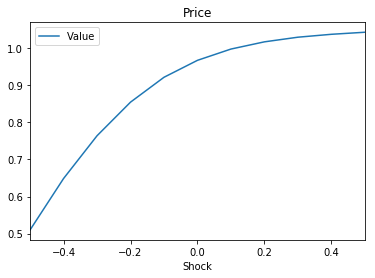

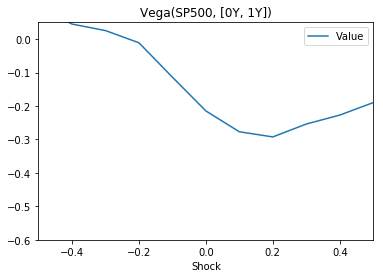

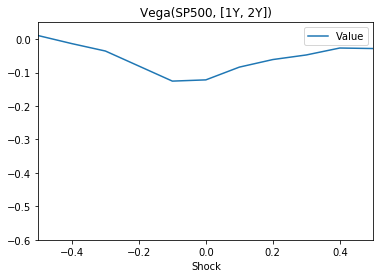

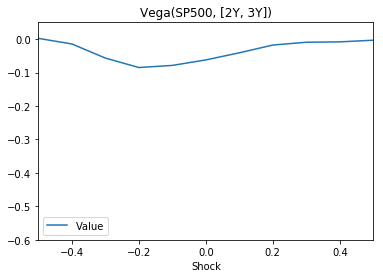

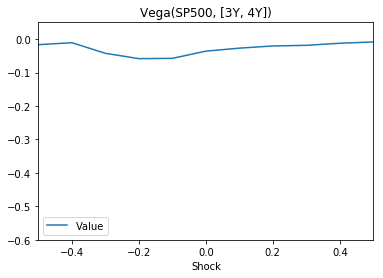

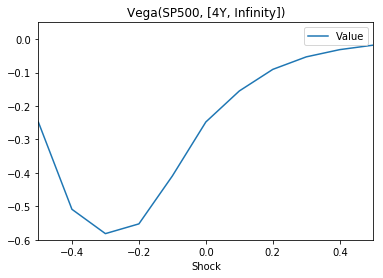

In [6]:
%matplotlib inline
for risk, profil in  results.groupby('Risk'): 
    if risk=='Price' :
        profil.plot(x='Shock', y='Value', title = risk)
    else:
        profil.plot(x='Shock', y='Value', title = risk, ylim=(-0.6,0.05))